# Predicting home prices in Ames, IA

The purpose of this notebook is for me to learn something about Python programming, how to process data using Python, and how to perform machine learning tasks in Python. It may perhaps also provide some decent predictions of house prices in Ames, IA.

This data holds quite a bit of interest for me, because my wife and I are currently going through the process on both sides of the table - we've put our current house on the market, and we have a new house under contract.

## 1 Import libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sb

## 2 Read in the data

In [2]:
train = pd.read_csv("./Data/train.csv", header=0)
train.head(5)
test = pd.read_csv("./Data/test.csv", header=0)

## 3 Data cleaning and exploration

Let's check to what extent we need to clean up the data before throwing a model at it. Let's also pick the features we are going to use, in order to cut down on the amount of cleaning we have to do - we can always expand it later.

### 3.1 Missing values

It looks like several columns have a lot of missing values. From the data dictionary provided, it seems that this should be expected. These should be interpreted as the absence of a given feature rather than a missing value. However, we're going to have to do something with them, because scikit-learn doesn't like them. Scikit also doesn't want the alpha fields, which appear to be categorical in nature.

In [3]:
print ("Training set rows:", len(train))
print ("Test set rows:", len(test))

Training set rows: 1460
Test set rows: 1459


In [4]:
train['SalePrice'].isnull().sum()

0

No missing sale prices either, so that's good.

### 3.2 Data exploration

There are 81 columns of data and 1460 rows. We don't want to go too nuts with the number of features here, as there will not be enough houses in any one set of feature values to obtain stable predictions.

Let's check out any missing values.

In [7]:
missing = len(train) - train.count()

In [8]:
missing.sort_values(ascending=False)[0:20]

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
Utilities          0
dtype: int64

So most houses do not have a pool, and don't have junk like extra garages, tennis courts, or elevators. In addition most don't have an alley access and don't have a fence. I have two enormous dogs - a Saint Bernard and a Greater Swiss Mountain Dog mix, so a fence would be a must for me - but I feel like most people would take that into account as regards their own situation, and that it wouldn't influence the price that much, all other things being equal.

All the garage information missing is for houses that didn't have a garage in the first place, and the same for the basement columns. 

#### 3.2.1 Neighborhoods

I am not from Ames, Iowa, so I don't know what meaning the names of the neighborhoods have. Let's see if we can get some from the training data.

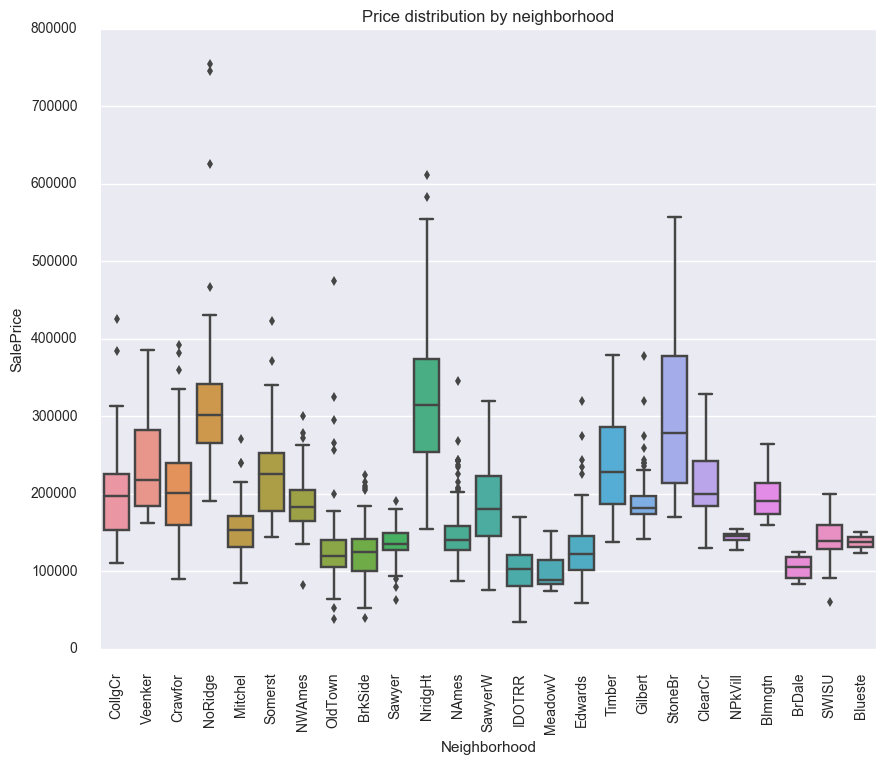

In [55]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
ax = plt.axes()
plot1 = sb.boxplot(data=train, x='Neighborhood', y='SalePrice')
ax.set_title("Price distribution by neighborhood")
sb.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.show()

Let's bucket these into "low", "middle", and "high" neighborhoods. This is a subjective assignment based on my lying eyes, and so it could fairly be argued about.

In [62]:
def transform_nb(x):
    if x in ("NoRidge", "NridgHt", "StoneBr","Timber","Veenker"):
        return "Hi"
    elif x in ("Mitchel","OldTown","BrkSide","Sawyer","NAmes","IDOTRR","MeadowV","Edwards","NPkVill","BrDale","Blueste"):
        return "Mid"
    else:
        return "Low"

In [63]:
train["NbdClass"] = train["Neighborhood"].apply(transform_nb)

In [64]:
set(train["NbdClass"])

{'Hi', 'Low', 'Mid'}

In [65]:
train["NbdClass"].value_counts()

Mid    700
Low    568
Hi     192
Name: NbdClass, dtype: int64

Let's redo the box plot by these three classes and see how it turns out:

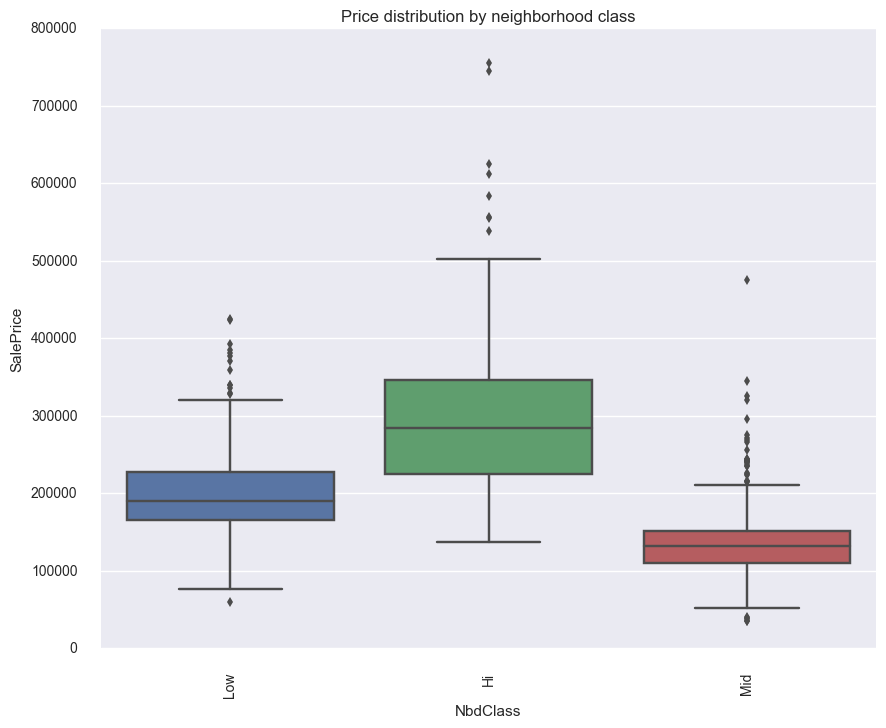

In [66]:
ax = plt.axes()
plot2 = sb.boxplot(data=train, x='NbdClass', y='SalePrice')
ax.set_title("Price distribution by neighborhood class")
sb.despine(offset=10, trim=True)
plt.xticks(rotation=90)
plt.show()

So that knocks a lot of categories down to three, in what I feel is a reasonable way. However, it does mean that the price of the "high" class neighborhoods may be harder to predict.

What else should we look at? They say people can get carried away looking at kitchens and bathrooms. There is a feature for kitchen quality, but none for bathroom quality, and condition of these isn't addressed at all. It's probably fair to assume that a large portion of the overall condition assessment covers the kitchen and bathrooms.